This file contains python code to compare with sinica paper

It is under the linear setting

Now, I use the same X and beta from the paper (on Sep 4, 2023)

I analyze the results under new code, here I save the results seperately.

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from joblib import Parallel, delayed

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2
import pandas as pd
from IPython.display import display


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT

from hdf_utils.hypo_test import obt_test_stat_simple2, get_Amat, obt_test_stat_simple3
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.misc import save_pkl, load_pkl, get_local_min_idxs
from optimization.one_step_opt import OneStepOpt


In [5]:
import logging

logger = logging.getLogger("tmp")
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler() # for console. 
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)

logger.addHandler(ch)

In [6]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Param and fns

## Fns

In [7]:
def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]
_err_fn = lambda x: np.nanmean(x**2)
#_err_fn = lambda x: np.nanmean(np.abs(x))

<function __main__.<lambda>(x)>

# Analysis

In [8]:
can_Ns = [4, 6, 8]
can_lams = [0.001, 0.1, 0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.6, 0.65, 0.7, 0.75, 0.80, 1.0, 2.0, 4.0, 16.0]
can_lams = [0.001, 0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 1.0, 2.0, 4.0, 16.0]

setting = "setting6a"

c1s = [0.0, 0.2, 0.4]
Cmat = np.eye(1) # change it depending on test1, test2, test3

#c1s = [0.5, 0.7, 0.9]
#Cmat = np.array([1, -1]).reshape(1, 2) # change it depending on test1, test2, test3

num_rep = 200;

## Step 0 (extract cv errrs)

Save in one dict

In [9]:
c1 = 0.0
cur_num_rep = 200
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    
    def _run_fn(seed, N, lam, c1):
        f_fil = list(cur_save_dir.glob(f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}-c1_{c1*1000:.0f}_est.pkl"))[0]
        t_res = load_pkl(f_fil, verbose=0)
        valsel_metrics = edict()
        valsel_metrics.cv_errs = t_res.cv_errs
        valsel_metrics.AIC = t_res.AIC
        valsel_metrics.BIC = t_res.BIC
        valsel_metrics.GCV = t_res.GCV
        return (seed, N, lam), valsel_metrics
    all_coms = itertools.product(range(cur_num_rep), can_Ns, can_lams)
    with Parallel(n_jobs=1) as parallel:
        all_cv_errs_list = parallel(delayed(_run_fn)(cur_seed, cur_N, cur_lam, c1=c1)  
                                 for cur_seed, cur_N, cur_lam
                                 in tqdm(all_coms, total=cur_num_rep*len(can_Ns)*len(can_lams), 
                                                      desc=f"c1: {c1}"))
    all_cv_errs = {res[0]:res[1] for res in all_cv_errs_list};
    save_pkl(cur_save_dir/f"all-valsel-metrics_c1_{c1*1000:.0f}.pkl", all_cv_errs, is_force=1)

c1: 0.4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10200/10200 [07:22<00:00, 23.06it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_400/all-valsel-metrics_c1_400.pkl


## Pre-ana

In [10]:
c1 = 0.0

0.0

In [11]:
def _run_fn1(seed, all_cv_errs):
    errs_mat = []
    for cur_N in can_Ns:
        errs = []
        for cur_lam in can_lams:
            #errs.append(all_cv_errs[(seed, cur_N, cur_lam)].BIC)
            errs.append(_err_fn(all_cv_errs[(seed, cur_N, cur_lam)].cv_errs))
        errs_mat.append(errs)
    errs_mat = np.array(errs_mat)
    return errs_mat
cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics_c1_{c1*1000:.0f}.pkl")
num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
# do not make n_jobs>1, it is very slow
with Parallel(n_jobs=1) as parallel:
    err_ten = parallel(delayed(_run_fn1)(cur_seed, all_cv_errs)  
                             for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
err_ten = np.array(err_ten);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_0/all-valsel-metrics_c1_0.pkl


c1: 0.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 747.60it/s]


In [12]:
err_ten_ses = err_ten.std(axis=0)/np.sqrt(err_ten.shape[0])
err_m = np.mean(np.array(err_ten), axis=0)
errs = []
for err in err_m:
    lam_min_idx = _get_min_idx(err)
    errs.append((err[lam_min_idx], lam_min_idx))
errs = np.array(errs)
N_min_idx = np.argmin(errs[:, 0]);
lam_min_idx = int(errs[N_min_idx][1]);
min_opt_N, min_opt_lam = can_Ns[N_min_idx], can_lams[lam_min_idx]
min_opt_N, min_opt_lam

err_upbd = err_m[N_min_idx, lam_min_idx] + err_ten_ses[N_min_idx, lam_min_idx]; 
lam_1se_idx = np.where(err_m[N_min_idx] <= err_upbd)[0].max();
(can_Ns[N_min_idx], can_lams[lam_min_idx], can_lams[lam_1se_idx])

(4, 0.25, 0.25)

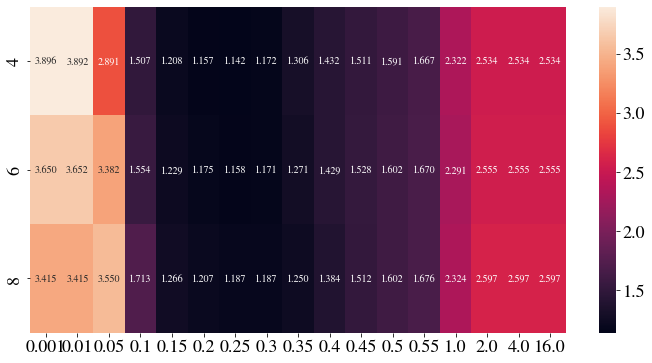

In [13]:
err_m = np.mean(np.array(err_ten), axis=0)
plt.figure(figsize=[12, 6])
sns.heatmap(err_m, annot=err_m, fmt=".3f")
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns);

## Step 2 (only need once)

In [14]:
def _test_fn(Cmat, est_res, svdinv_eps_Q=0, svdinv_eps_Psi=0):
    torch.set_default_tensor_type(torch.DoubleTensor)
    _paras = est_res._paras
    _paras.svdinv_eps_Q = svdinv_eps_Q
    _paras.svdinv_eps_Psi = svdinv_eps_Psi
    #f_name = f"seed_{_paras.seed:.0f}-lam_{_paras.lam*1000:.0f}-N_{_paras.N:.0f}_test_stat.pkl"
    
    T_v = obt_test_stat_simple2(Q_mat_part=est_res.Q_mat_part,
                               Sig_mat_part=est_res.Sig_mat_part,
                               est_alp=est_res.est_alp, 
                               est_Gam=est_res.est_Gam,
                               Cmat=Cmat,
                               paras=_paras,
                               ).item() 
    pval = chi2.sf(T_v, Cmat.shape[0]*_paras.N)
    
    res = edict()
    res.T_v = T_v
    res.pval = pval
    res.Cmat = Cmat
    return res

In [15]:
def _test_fn1(Cmat, est_res, svdinv_eps_Q=0, svdinv_eps_Psi=0):
    torch.set_default_tensor_type(torch.DoubleTensor)
    _paras = est_res._paras
    _paras.svdinv_eps_Q = svdinv_eps_Q
    _paras.svdinv_eps_Psi = svdinv_eps_Psi
    
    T_v = obt_test_stat_simple3(est_sigma2=est_res.est_sigma2,
                               Q_mat_part=est_res.Q_mat_part, 
                               est_alp=est_res.est_alp, 
                               est_Gam=est_res.est_Gam,
                               Cmat=Cmat,
                               paras=_paras,
                               ).item() 
    pval = chi2.sf(T_v, Cmat.shape[0]*_paras.N)
    
    res = edict()
    res.T_v = T_v
    res.pval = pval
    res.Cmat = Cmat
    return res

### Fix N and adaptive lam

In [34]:
# then given N, find opt lam
def _run_fn_fixN(seed, optN, all_cv_errs):
    errs = []
    for cur_lam in can_lams:
        errs.append(_err_fn(all_cv_errs[(seed, optN, cur_lam)].cv_errs))
    min_idx = _get_min_idx(errs);
    return (seed, optN, can_lams[min_idx], errs[min_idx])

optN = 6
opt_lamss = dict()
for c1 in tqdm(c1s):
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics_c1_{c1*1000:.0f}.pkl")
    num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
    opt_lams = [_run_fn_fixN(seed, optN, all_cv_errs) for seed in range(num_seed)]
    opt_lamss[c1] = opt_lams

  0%|                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting5_0/all-valsel-metrics_c1_0.pkl


 33%|██████████████████████████████████████████████▋                                                                                             | 1/3 [00:01<00:03,  1.96s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting5_200/all-valsel-metrics_c1_200.pkl


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2/3 [00:03<00:01,  1.95s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting5_400/all-valsel-metrics_c1_400.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.96s/it]


In [53]:
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
cans = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    opt_lamNs =  opt_lamss[c1]
    ress = []
    for cur_seed, cur_N, cur_lam, _ in tqdm(opt_lamNs, desc=f"c1: {c1*1000:.0f}"):
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_est.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res = []
        with Parallel(n_jobs=20) as parallel:
            res = parallel(delayed(_test_fn1)(Cmat=Cmat, est_res=res1, 
                                             svdinv_eps_Q=rtols[0], 
                                             svdinv_eps_Psi=rtols[1]) for rtols
                                             in all_coms)
    
        ress.append(res)
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNsfixN_c1_{c1*1000:.0f}_ress.pkl", ress, is_force=1)

c1: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.42it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting5_0/opt_lamNsfixN_c1_0_ress.pkl


c1: 200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.91it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting5_200/opt_lamNsfixN_c1_200_ress.pkl


c1: 400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.41it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting5_400/opt_lamNsfixN_c1_400_ress.pkl


### Fix N and adaptive lam but 1se

In [ ]:
def _get_cv_se(cv_errs, num_fold):
    """Get CV SE to use the one standard error rule.
        (from zotero://select/library/items/BPMP3MBP)
    """
    cv_errs_mul = cv_errs.reshape(num_fold, -1);
    sd = np.std(np.mean(cv_errs_mul**2, axis=-1))
    se = sd/np.sqrt(num_fold)
    return se

In [85]:
optN = 6
c1 = 0
optlamss_1se = {}
for c1 in c1s:
    def _run_fn1(seed, all_cv_errs):
        errs_mat = []
        for cur_N in can_Ns:
            errs = []
            for cur_lam in can_lams:
                #errs.append(all_cv_errs[(seed, cur_N, cur_lam)].BIC)
                errs.append(_err_fn(all_cv_errs[(seed, cur_N, cur_lam)].cv_errs))
            errs_mat.append(errs)
        errs_mat = np.array(errs_mat)
        return errs_mat
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics_c1_{c1*1000:.0f}.pkl")
    num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
    # do not make n_jobs>1, it is very slow
    with Parallel(n_jobs=1) as parallel:
        err_ten = parallel(delayed(_run_fn1)(cur_seed, all_cv_errs)  
                                 for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
    def _run_fn2(seed, all_cv_errs):
        errs_mat = []
        for cur_N in can_Ns:
            errs = []
            for cur_lam in can_lams:
                #errs.append(all_cv_errs[(seed, cur_N, cur_lam)].BIC)
                errs.append(_get_cv_se(all_cv_errs[(seed, cur_N, cur_lam)].cv_errs, num_fold=20))
            errs_mat.append(errs)
        errs_mat = np.array(errs_mat)
        return errs_mat
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics_c1_{c1*1000:.0f}.pkl")
    num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
    # do not make n_jobs>1, it is very slow
    with Parallel(n_jobs=1) as parallel:
        err_se_ten = parallel(delayed(_run_fn2)(cur_seed, all_cv_errs)  
                                 for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
    err_ten = np.array(err_ten);
    err_se_ten = np.array(err_se_ten);
    
    err_ten_optN = err_ten[:, can_Ns.index(optN)]
    err_se_ten_optN = err_se_ten[:, can_Ns.index(optN)];
    optlams_1se = []
    for cur_seed in range(num_rep):
        min_idx_lam = _get_min_idx(err_ten_optN[cur_seed])
        upbd = err_ten_optN[cur_seed, min_idx_lam] + err_se_ten_optN[cur_seed, min_idx_lam]
        min1se_idx_lam = np.max(np.where(err_ten_optN[cur_seed]<=upbd)[0])
        optlams_1se.append((cur_seed, optN, can_lams[min1se_idx_lam]))
    optlamss_1se[c1] = optlams_1se

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_0/all-valsel-metrics_c1_0.pkl


c1: 0.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 753.69it/s]


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_0/all-valsel-metrics_c1_0.pkl


c1: 0.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 626.02it/s]


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_200/all-valsel-metrics_c1_200.pkl


c1: 0.2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 700.49it/s]


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_200/all-valsel-metrics_c1_200.pkl


c1: 0.2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 631.33it/s]


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_400/all-valsel-metrics_c1_400.pkl


c1: 0.4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 705.06it/s]


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_400/all-valsel-metrics_c1_400.pkl


c1: 0.4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 624.47it/s]


In [87]:
# for adaptive lam N
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    optlams_1se =  optlamss_1se[c1]
    ress = []
    for cur_seed, cur_N, cur_lam in tqdm(optlams_1se, desc=f"c1: {c1*1000:.0f}"):
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_est.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res = []
        with Parallel(n_jobs=20) as parallel:
            res = parallel(delayed(_test_fn1)(Cmat=Cmat, est_res=res1, 
                                             svdinv_eps_Q=rtols[0], 
                                             svdinv_eps_Psi=rtols[1]) for rtols
                                             in all_coms)
    
        ress.append(res)
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNsfixN1se_c1_{c1*1000:.0f}_ress.pkl", ress, is_force=1)

c1: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.25it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_0/opt_lamNsfixN1se_c1_0_ress.pkl


c1: 200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.91it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_200/opt_lamNsfixN1se_c1_200_ress.pkl


c1: 400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.51it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_400/opt_lamNsfixN1se_c1_400_ress.pkl


### Adaptive N and lam

In [25]:
def _run_fn(seed, all_cv_errs):
    errs_N = []
    for cur_N in can_Ns:
        errs = []
        for cur_lam in can_lams:
            #errs.append(_err_fn(all_cv_errs[(seed, cur_N, cur_lam)].GCV))
            errs.append(_err_fn(all_cv_errs[(seed, cur_N, cur_lam)].cv_errs))
        min_idx = _get_min_idx(errs);
        errs_N.append((seed, cur_N, can_lams[min_idx], errs[min_idx]))
    errs_N_sorted = sorted(errs_N, key=lambda x:x[-1]);
    return errs_N_sorted[0]

opt_lamNss = dict()
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics_c1_{c1*1000:.0f}.pkl")
    num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
    # do not make n_jobs>1, it is very slow
    with Parallel(n_jobs=1) as parallel:
        opt_lamNs = parallel(delayed(_run_fn)(cur_seed, all_cv_errs)  
                             for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
    opt_lamNss[c1] = opt_lamNs

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_0/all-valsel-metrics_c1_0.pkl


c1: 0.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 718.01it/s]


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_200/all-valsel-metrics_c1_200.pkl


c1: 0.2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 724.88it/s]


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_400/all-valsel-metrics_c1_400.pkl


c1: 0.4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 711.01it/s]


In [26]:
# for adaptive lam N
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    opt_lamNs =  opt_lamNss[c1]
    ress = []
    for cur_seed, cur_N, cur_lam, _ in tqdm(opt_lamNs, desc=f"c1: {c1*1000:.0f}"):
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_est.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res = []
        with Parallel(n_jobs=20) as parallel:
            res = parallel(delayed(_test_fn1)(Cmat=Cmat, est_res=res1, 
                                             svdinv_eps_Q=rtols[0], 
                                             svdinv_eps_Psi=rtols[1]) for rtols
                                             in all_coms)
    
        ress.append(res)
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}_ress.pkl", ress, is_force=1)

c1: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 16.93it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_0/opt_lamNs_c1_0_ress.pkl


c1: 200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.10it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_200/opt_lamNs_c1_200_ress.pkl


c1: 400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.93it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4d_400/opt_lamNs_c1_400_ress.pkl


In [45]:
for k, v in opt_lamNss.items():
    v = np.array(v)[:, 1:3]
    combos, cts = np.unique(v, axis=0, return_counts=1)
    tres = np.concatenate([combos, cts.reshape(-1, 1)], axis=1)
    display(pd.DataFrame(tres));

,0,1,2
0,4.0,0.30,6.0
1,4.0,0.45,6.0
2,4.0,0.55,1.0
3,4.0,16.00,1.0
4,6.0,0.30,39.0
5,6.0,0.45,45.0
6,6.0,0.50,19.0
7,6.0,0.55,20.0
8,6.0,0.60,7.0
9,6.0,0.70,1.0


,0,1,2
0,4.0,0.30,7.0
1,4.0,0.45,2.0
2,6.0,0.10,1.0
3,6.0,0.30,44.0
4,6.0,0.45,47.0
5,6.0,0.50,16.0
6,6.0,0.55,18.0
7,6.0,0.60,10.0
8,6.0,0.70,1.0
9,6.0,1.00,1.0


,0,1,2
0,4.0,0.30,5.0
1,4.0,0.45,1.0
2,6.0,0.30,47.0
3,6.0,0.45,44.0
4,6.0,0.50,16.0
5,6.0,0.55,15.0
6,6.0,0.60,12.0
7,6.0,0.70,1.0
8,6.0,1.00,1.0
9,6.0,16.00,2.0


### Fixed N and fixed lam

In [16]:
def _run_fn1(seed, all_cv_errs):
    errs_mat = []
    for cur_N in can_Ns:
        errs = []
        for cur_lam in can_lams:
            #errs.append(all_cv_errs[(seed, cur_N, cur_lam)].BIC)
            errs.append(_err_fn(all_cv_errs[(seed, cur_N, cur_lam)].cv_errs))
        errs_mat.append(errs)
    errs_mat = np.array(errs_mat)
    return errs_mat
opt_lamNs_fix = {}
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics_c1_{c1*1000:.0f}.pkl")
    num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
    # do not make n_jobs>1, it is very slow
    with Parallel(n_jobs=1) as parallel:
        err_ten = parallel(delayed(_run_fn1)(cur_seed, all_cv_errs)  
                                 for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
    err_ten = np.array(err_ten);
    
    err_ten_ses = err_ten.std(axis=0)/np.sqrt(err_ten.shape[0])
    err_m = np.mean(np.array(err_ten), axis=0)
    errs = []
    for err in err_m:
        lam_min_idx = _get_min_idx(err)
        errs.append((err[lam_min_idx], lam_min_idx))
    errs = np.array(errs)
    N_min_idx = np.argmin(errs[:, 0]);
    lam_min_idx = int(errs[N_min_idx][1]);
    min_opt_N, min_opt_lam = can_Ns[N_min_idx], can_lams[lam_min_idx]
    
    err_upbd = err_m[N_min_idx, lam_min_idx] + err_ten_ses[N_min_idx, lam_min_idx]; 
    lam_1se_idx = np.where(err_m[N_min_idx] <= err_upbd)[0].max();
    print(can_Ns[N_min_idx], can_lams[lam_min_idx], can_lams[lam_1se_idx])
    opt_lamNs_fix[c1] = (can_Ns[N_min_idx],  can_lams[lam_1se_idx])

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_0/all-valsel-metrics_c1_0.pkl


c1: 0.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 762.44it/s]


4 0.25 0.25
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_200/all-valsel-metrics_c1_200.pkl


c1: 0.2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 749.71it/s]


4 0.25 0.25
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_400/all-valsel-metrics_c1_400.pkl


c1: 0.4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 750.29it/s]

4 0.25 0.25


In [17]:
opt_lamNs_fix

{0.0: (4, 0.25), 0.2: (4, 0.25), 0.4: (4, 0.25)}

In [24]:
# for adaptive lam N
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    cur_N, cur_lam = opt_lamNs_fix[c1]
    #cur_lam = 2.0
    ress = []
    for cur_seed in tqdm(range(num_rep), desc=f"c1: {c1*1000:.0f}"):
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_est.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res = []
        with Parallel(n_jobs=20) as parallel:
            res = parallel(delayed(_test_fn1)(Cmat=Cmat, est_res=res1, 
                                             svdinv_eps_Q=rtols[0], 
                                             svdinv_eps_Psi=rtols[1]) for rtols
                                             in all_coms)
    
        ress.append(res)
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNsfixNlam_c1_{c1*1000:.0f}_ress.pkl", ress, is_force=1)

c1: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.55it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_0/opt_lamNsfixNlam_c1_0_ress.pkl


c1: 200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.42it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_200/opt_lamNsfixNlam_c1_200_ress.pkl


c1: 400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.75it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_400/opt_lamNsfixNlam_c1_400_ress.pkl


## Find Q and Psi rtol

In [25]:
ress_dict = {}
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    #ress = load_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}_ress.pkl");
    #ress = load_pkl(cur_save_dir/f"opt_lamNsfixN_c1_{c1*1000:.0f}_ress.pkl");
    #ress = load_pkl(cur_save_dir/f"opt_lamNsfixN1se_c1_{c1*1000:.0f}_ress.pkl");
    ress = load_pkl(cur_save_dir/f"opt_lamNsfixNlam_c1_{c1*1000:.0f}_ress.pkl");
    ress_dict[c1] = ress

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_0/opt_lamNsfixNlam_c1_0_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_200/opt_lamNsfixNlam_c1_200_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting6a_400/opt_lamNsfixNlam_c1_400_ress.pkl


In [26]:
import pandas as pd
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]

all_coms = np.array(list(itertools.product(cans, cans)));
all_coms = [(can, can) for can in cans]
kpidxs = []

df = []
for c1 in c1s:
    ress = ress_dict[c1]
    pvals = np.array([[re["pval"] for re in res] for res in ress]);
    vec_pv = np.mean(pvals<0.05, axis=0)
    df.append(vec_pv[:, np.newaxis])
df.append(all_coms) 
df = np.hstack(df)
df = pd.DataFrame(df) 
df.columns = c1s+["Q", "Psi"]
df

,0.0,0.2,0.4,Q,Psi
0,0.645,0.76,0.990,1.000000e-05,1.000000e-05
1,0.010,0.28,0.965,3.000000e-06,3.000000e-06
2,0.010,0.28,0.965,1.000000e-06,1.000000e-06
3,0.010,0.28,0.965,3.000000e-07,3.000000e-07
4,0.010,0.28,0.965,1.000000e-07,1.000000e-07
5,0.010,0.28,0.965,3.000000e-08,3.000000e-08
6,0.010,0.28,0.965,1.000000e-08,1.000000e-08
7,0.010,0.28,0.965,3.000000e-09,3.000000e-09
8,0.010,0.28,0.965,1.000000e-09,1.000000e-09
9,0.010,0.28,0.965,3.000000e-10,3.000000e-10


# Sinica results

In [71]:
setting = "setting5"
sini_paras = edict()
sini_paras.dir = RES_ROOT/f"sinica_results/SinicaX_d-200_n-100_{setting}";
c1s = [0.0, 0.2, 0.4]

[0.0, 0.2, 0.4]

In [72]:
pvals_sinica = []
pvalss_sinica = []
for c1 in c1s:
    all_fils = list(sini_paras.dir.glob(f"c1_{c1*1000:.0f}_*.mat"));
    sorted_all_fils = sorted(all_fils, key=lambda x: int(x.stem.split("_")[3]));
    
    sini_pvals = []
    opt_sns = []
    for fil in sorted_all_fils:
        res = loadmat(fil);
        sini_pvals.append(res["pval"][0][0])
        opt_sns.append(res["gopt_sn"][0][0])
    sini_pvals = np.array(sini_pvals);
    opt_sns = np.array(opt_sns);
    #save_pkl(sini_paras.dir/f"c1_{c1*1000:.0f}_pvals.pkl", sini_pvals, is_force=False)
    pvalss_sinica.append(sini_pvals)
    pvals_sinica.append(np.mean(sini_pvals < 0.05))
    print(f"The power under c1={c1:.3f} {len(sini_pvals)} is {np.mean(sini_pvals < 0.05):.3f}.")

The power under c1=0.000 200 is 0.040.
The power under c1=0.200 200 is 0.465.
The power under c1=0.400 200 is 0.975.
